In [1]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import uniform
from scipy.stats import multivariate_normal

In [2]:
def prior_sample():
    # Sample from prior distribution
    # For univariate alpha-stable models, sample each parameter from its respective uniform distribution
    #np.random.seed(seed)
    alpha = uniform.rvs(1.1, 0.9)  # U[1.1, 2]
    beta = uniform.rvs(-1, 2)  # U[-1, 1]
    gamma = uniform.rvs(0, 300)  # U[0, 300]
    delta = uniform.rvs(-300, 600)  # U[-300, 300]
    return [alpha, beta, gamma, delta]

In [3]:
def univ_alpha_stable_sampler(params,size,seed) :
    alpha,beta,gamma,delta = params[0],params[1],params[2],params[3]
    #print(alpha,beta,gamma,delta)
    y_bar = 0
    np.random.seed(seed)
    w = np.random.standard_exponential(size=size)
    u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = size)
    if alpha == 1 :
        y_bar = 2/np.pi*((np.pi/2+beta*u)*np.tan(u)-beta*np.log((np.pi/2*w*np.cos(u))/(np.pi/2+beta*u)))
        return gamma*y_bar + delta
    else :
        S = (1+beta**2*np.tan(np.pi*alpha/2)**2)**(1/(2*alpha))
        B = 1/alpha*np.arctan(beta*np.tan(np.pi*alpha/2))
        #print(S,B)
        y_bar = (S*(np.sin(alpha)*(u+B))*(np.cos(u-alpha*(u+B))/w)**((1-alpha)/alpha))/np.cos(u)**(1/alpha)
        return gamma*y_bar + delta

In [4]:
def compute_quantiles(data):
    # Compute quantile-based summary statistics
    quantiles = np.percentile(data, [5, 25, 50, 75, 95])
    v_alpha = (quantiles[4] - quantiles[0]) / (quantiles[3] - quantiles[1])
    v_beta = (quantiles[4] + quantiles[0] - 2 * quantiles[2]) / (quantiles[4] - quantiles[0])
    v_gamma = (quantiles[3] - quantiles[1]) / quantiles[2]
    return v_alpha, v_beta, v_gamma

In [5]:
def S(data):
    # Compute summary statistics of the data
    # This function should return low-dimensional summary statistics S(data)
    # For univariate alpha-stable models, use quantile-based estimators along with the mean of the data
    v_alpha, v_beta, v_gamma = compute_quantiles(data)
    mean_x = np.mean(data)
    return np.array([v_alpha, v_beta, v_gamma, mean_x])

In [6]:
def psi(y, x, covariance = np.diag([0.25,0.25,1,1])):
    # Define smoothing kernel using a Gaussian kernel with estimated covariance
    return multivariate_normal.pdf(y, mean=x, cov=covariance)


In [7]:
def cov_estimate(theta_hat,n_draws = 1000):
    x = np.array([univ_alpha_stable_sampler(params = theta_hat, size = 200, seed=None) for _ in range(n_draws)])
    sumary_statistics = np.array([S(x_i) for x_i in x])

    return np.cov(sumary_statistics, rowvar=False)

In [8]:
def norm2(u) :
    return np.sqrt(np.sum(u*u))


In [9]:
def K(u, sigma) :
    d = 4
    return np.exp(-(u.T@np.linalg.inv(sigma)@u)/2)/(np.sqrt(2*np.pi)**d*np.sqrt(np.linalg.det(sigma)))




In [10]:
def resample(theta, weights,N) :
    normalized_weights = weights['t']/np.sum(weights['t'])
    print(theta['t-1'].shape)
    new_indices = np.random.choice(range(N),replace=True, p=normalized_weights)
    theta['t'] = theta['t'][new_indices]

    weights['t'] = np.ones(N)/N

In [11]:
def sample_from_M_t(N, theta_prev, weights_prev):
    normalized_weights = weights_prev/np.sum(weights_prev)
    # Choose a component based on the weights
    component = np.random.choice(range(N), p=normalized_weights)
    # Generate a sample from the chosen component
    sample = np.random.multivariate_normal(mean = theta_prev[component], cov = np.diag([0.25,0.25,1,1]))
    #samples[i] = sample
    return sample 

In [12]:
def M_t(N,theta_i,theta_prev, weights_prev) :
    densities = np.array([ psi(theta_i, theta_prev[i]) for i in range(N)])
    return np.sum(weights_prev*densities)
    

In [13]:
def normalize(u) :
    return u/np.sum(u)


In [14]:
def prior_density(theta_i) :
    alpha,beta,gamma,delta = theta_i[0],theta_i[1],theta_i[2],theta_i[3]
    return uniform.pdf(alpha,1.1,0.9)*uniform.pdf(beta,-1,2)*uniform.pdf(gamma,0,300)*uniform.pdf(delta,-300,600)

In [15]:
round(0.001,5)

0.001

In [16]:
def initialization(T=10,N =1000,n=200,covariance = np.diag([0.25, 0.25, 1, 1]), seed=42) :
    #epsilons = [k for k in range(1000,100, -100)]+[k for k in range(100,9, -1)] + [k+0.5 for k in range(9,4,-1)] + [5-k*0.05 for k in range(40)]+[3-0.01*k for k in range(301)]  # Tolerance schedule
    epsilons = [10*k for k in range(10,0,-1)]
    T = len(epsilons)
    y = levy_stable.rvs(1.7, 0.9, loc=10, scale=10, size=200)
    ###--------Initialization :
    epsilon = epsilons[0]
    
    #sigma_hat = np.diag([0.25,0.25,1,1])
    sigma_hat = cov_estimate(np.array([1.7,0.9,10,10]))
    print("sigma_hat = ", sigma_hat)
    print('det(sigma_hat) = ', np.linalg.det(sigma_hat))
    # 1 - sample theta from the prior : 
    # theta is a Nx4 matrix containing all the N theta_i
    initial_theta = np.array([prior_sample() for _ in range(N)])
    theta = {"t" : initial_theta , "t-1" :initial_theta }
    print('theta["t"] = ',np.round(theta['t'][:5],4))
    # set weights their initial values :
    x = np.array([levy_stable.rvs(theta['t'][i][0], theta['t'][i][1], loc=theta['t'][i][3], scale=theta['t'][i][2], size=200) for i in range(N)])
    #x = np.array([univ_alpha_stable_sampler(params=theta['t'][i], size=n, seed=None) for i in range(N)])
    print('x.shape = ',x.shape)
    print('x',x)
    #print([S(x[i]) for i in range(5)])
    #print([K((S(y)-S(x[i]))/epsilon,sigma_hat)/epsilon for i in range(5)])
    initial_weights = np.array([K((S(y)-S(x[i])),epsilon**2*sigma_hat) for i in range(N)])
    print("weights = ", initial_weights)

    #print(" sum(weights) = ", np.sum(normalize(initial_weights)))

    #weights = {"t" : normalize(initial_weights), "t-1" : normalize(initial_weights)}
    weights = {"t" : initial_weights, "t-1" : initial_weights}
    return y,x,theta,weights,sigma_hat

In [17]:
def SMC_sampler_v2(arg, T=10,N =1000,n=200,covariance = np.diag([0.25, 0.25, 1, 1]), seed=42) :
    #epsilons = [k for k in range(1000,100, -100)]+[k for k in range(100,9, -1)] + [k+0.5 for k in range(9,4,-1)] + [5-k*0.05 for k in range(40)]+[3-0.01*k for k in range(301)]  # Tolerance schedule
    epsilons = [10*k for k in range(10,0,-1)]
    T = len(epsilons)

    #y = levy_stable.rvs(1.7, 0.9, loc=10, scale=10, size=200)
    ###--------Initialization :
    epsilon = epsilons[0]
    # 1 - sample theta from the prior : 
    # theta is a Nx4 matrix containing all the N theta_i
    #initial_theta = np.array([prior_sample(seed) for _ in range(N)])
    #theta = {"t" : initial_theta , "t-1" :initial_theta }
    # set weights their initial values :
    #x = np.array([univ_alpha_stable_sampler(params=theta['t'][i], size=n, seed=seed) for i in range(N)])
    #print('x.shape = ',x.shape)
    #initial_weights = np.array([K((S(y)-S(x))/epsilon,sigma_hat(theta_hat))/epsilon for theta_hat in theta['t']])
    #print("weights = ", initial_weights)
    #print(" sum(weights) = ", np.sum(initial_weights))
    #weights = {"t" : initial_weights, "t-1" : initial_weights}
    y,x,theta,weights,sigma_hat = arg
    t=1
    res = []
    sigma_hat = cov_estimate(np.array([1.7,0.9,10,10]))
    """
    weigths['t'] = np.ones(N)/N
    weights['t-1'] = np.ones(N)/N
    """
    print("INITIALIZATION IS DONE :)")
    while t<T :
        print("t = ",t)
        epsilon = epsilons[t]
        print("epsilon = ",epsilon)
        theta_maj = theta['t']
        weights_maj = weights['t']
        i = 0 
        #max_iter = 10
        #nb_iter = 0
        c_t = np.quantile(weights['t'], 0.9)
        while i<N : 
            print('###########    i = ',i)
            """
            weights['t'] = normalize(weights['t'])
            weights['t-1'] = normalize(weights['t-1'])
            """
            #c_t = np.quantile(weights['t'], 0.9)

            #print("nb_iter = ",nb_iter)
            # Mutation and correction : 
            theta['t'][i] = sample_from_M_t(N, theta['t-1'], weights['t-1'])
            #print(f'theta["t"][{i}]= ', np.round(theta['t'][i],3))
            #sigma_hat = cov_estimate(np.array([1.7,0.9,10,10]))
            print("S(y) = ", S(y))
            #print(f"x[{i}]=",x[i])
            print(f"S(x[{i}]) =", S(x[i]))
            weights['t'][i] = (K((S(y)-S(x[i])),(epsilon**2)*sigma_hat))*prior_density(theta['t'][i])/M_t(N,theta['t'][i],theta['t-1'],weights['t-1'])
            print("poids = ", K((S(y)-S(x[i])),(epsilon**2)*sigma_hat)*prior_density(theta['t'][i])/M_t(N,theta['t'][i],theta['t-1'],weights['t-1']))
            print(f"prior(theta_{i}) = {prior_density(theta['t'][i])}")
            print(f"noyau = {K((S(y)-S(x[i]))/epsilon,(epsilon**2)*sigma_hat)/epsilon}")
            print(f" M_t = {M_t(N,theta['t'][i],theta['t-1'],weights['t-1'])}")
            """
            weights['t'] = normalize(weights['t'])
            weights['t-1'] = normalize(weights['t-1'])
            """
            #print('weights["t"] = ', np.round(weights['t'][:5],3))
            #theta['t-1'] = theta_maj
            #weights['t-1'] = weights_maj
            u = np.random.uniform(low=0, high=1)
            #c_t = np.quantile(weights['t'], 0.9)
            proba = 1-np.minimum(1,weights['t']/c_t)
            
            print("c_t = ", c_t)
            print(f"weights['t'][{i}] = ", weights['t'][i])
            print('sum(weights) = ', np.sum(weights['t']))
            print(f'proba[{i}] = ', proba[i])
            """
            if nb_iter == max_iter: 
                i=i+1
                n_iter = 0
                continue
            """
            if u<=proba[i] :
                #Rejection : 
                print(f"theta['t'][{i}] = {np.round(theta['t'][i],3)} rejected !")
                #nb_iter+=1
                continue
            else : 
                # Acceptance
                print(f"theta['t'][{i}] = {np.round(theta['t'][i],3)} accepted !")
                weights['t'][i] = weights['t'][i]/(1-proba[i])
                i = i+1
                #nb_iter = 0
        t+=1
        theta['t-1'],weights['t-1'] = theta_maj,weights_maj
        res.append((theta['t'], weights['t']))
        # Resample : 
        weights['t'] = np.ones(N)/N
        weights['t-1'] = np.ones(N)/N
        print("theta = ", theta['t'][:5])
        print("weights = ", weights['t'][:5])


In [18]:
arg = initialization()

sigma_hat =  [[ 2.42935925e+00 -1.03398768e-01 -1.45508063e-01 -6.03359555e+00]
 [-1.03398768e-01  2.21060146e-02 -2.22443933e-02  7.73161939e-01]
 [-1.45508063e-01 -2.22443933e-02  3.28281211e-01 -1.91366074e+00]
 [-6.03359555e+00  7.73161939e-01 -1.91366074e+00  3.52630656e+02]]
det(sigma_hat) =  3.7103669417945766
theta["t"] =  [[ 1.334100e+00 -1.387000e-01  8.159990e+01 -2.046585e+02]
 [ 1.434000e+00 -8.119000e-01  1.241925e+02  2.778247e+02]
 [ 1.610400e+00 -2.948000e-01  1.124106e+02 -6.031100e+00]
 [ 1.241500e+00  2.137000e-01  2.055596e+02 -8.032930e+01]
 [ 1.322200e+00 -8.229000e-01  1.960027e+02  4.986180e+01]]
x.shape =  (1000, 200)
x [[-133.36442549  -25.8875682  -225.88284496 ... -130.62241157
  -124.53460726 -134.02141131]
 [ 472.06534958  546.75765338  435.23095744 ...  174.8451663
   451.2061679    52.41880591]
 [ 207.0528325    90.62292517  -49.03428149 ... -159.7265061
   143.40161141  -45.27253718]
 ...
 [ 122.06629712  545.10614946  303.91836938 ...  571.98796962
  

In [20]:
N =1000
n=200
covariance = np.diag([0.25, 0.25, 1, 1])
seed=42
#epsilons = [k for k in range(1000,100, -100)]+[k for k in range(100,9, -1)] + [k+0.5 for k in range(9,4,-1)] + [5-k*0.05 for k in range(40)]+[3-0.01*k for k in range(301)]  # Tolerance schedule
epsilons = [10*k for k in range(10,0,-1)]
T = len(epsilons)
y,theta,weights,sigma_hat = arg
t=1
res = []
sigma_hat = cov_estimate(np.array([1.7,0.9,10,10]))

weights['t'] = np.ones(N)/N
weights['t-1'] = np.ones(N)/N

print("INITIALIZATION IS DONE :)")
while t<T :
    print("t = ",t)
    epsilon = epsilons[t]
    print("epsilon = ",epsilon)
    theta_maj = theta['t']
    weights_maj = weights['t']
    i = 0 
    #max_iter = 10
    #nb_iter = 0
    c_t = np.quantile(weights['t'], 0.9)
    while i<N : 
        print('###########    i = ',i)
        """
        weights['t'] = normalize(weights['t'])
        weights['t-1'] = normalize(weights['t-1'])
        """
        #c_t = np.quantile(weights['t'], 0.9)

        #print("nb_iter = ",nb_iter)
        # Mutation and correction : 
        theta['t'][i] = sample_from_M_t(N, theta['t-1'], weights['t-1'])
        #print(f'theta["t"][{i}]= ', np.round(theta['t'][i],3))
        #sigma_hat = cov_estimate(np.array([1.7,0.9,10,10]))
        print("S(y) = ", S(y))
        #print(f"x[{i}]=",x[i])
        print(f"S(x[{i}]) =", S(x[i]))
        weights['t'][i] = (K((S(y)-S(x[i])),(epsilon**2)*sigma_hat))*prior_density(theta['t'][i])/M_t(N,theta['t'][i],theta['t-1'],weights['t-1'])
        #print("poids = ", K((S(y)-S(x[i])),(epsilon**2)*sigma_hat)*prior_density(theta['t'][i])/M_t(N,theta['t'][i],theta['t-1'],weights['t-1']))
        print(f"prior(theta_{i}) = {prior_density(theta['t'][i])}")
        print(f"noyau = {K((S(y)-S(x[i]))/epsilon,(epsilon**2)*sigma_hat)/epsilon}")
        print(f" M_t = {M_t(N,theta['t'][i],theta['t-1'],weights['t-1'])}")
        """
        weights['t'] = normalize(weights['t'])
        weights['t-1'] = normalize(weights['t-1'])
        """
        #print('weights["t"] = ', np.round(weights['t'][:5],3))
        #theta['t-1'] = theta_maj
        #weights['t-1'] = weights_maj
        u = np.random.uniform(low=0, high=1, size=1)
        #c_t = np.quantile(weights['t'], 0.9)
        proba = 1-np.minimum(1,weights['t']/c_t)
        
        print("c_t = ", c_t)
        print(f"weights['t'][{i}] = ", weights['t'][i])
        print('norm(weights)**2 = ', norm2(weights['t'])**2)
        print("w_i/ct = ", weights['t'][i]/c_t)
        print(f'proba[{i}] = ', proba[i])
        """
        if nb_iter == max_iter: 
            i=i+1
            n_iter = 0
            continue
        """
        if u<=proba[i] :
            #Rejection : 
            print(f"theta['t'][{i}] = {np.round(theta['t'][i],3)} rejected !")
            #nb_iter+=1
            continue
        else : 
            # Acceptance
            print(f"theta['t'][{i}] = {np.round(theta['t'][i],3)} accepted !")
            weights['t'][i] = weights['t'][i]/(1-proba[i])
            i = i+1
            #nb_iter = 0
    t+=1
    theta['t-1'],weights['t-1'] = theta_maj,weights_maj
    res.append((theta['t'], weights['t']))
    # Resample : 
    weights['t'] = np.ones(N)/N
    weights['t-1'] = np.ones(N)/N
    print("theta = ", theta['t'][:5])
    print("weights = ", weights['t'][:5])

INITIALIZATION IS DONE :)
t =  1
epsilon =  90
###########    i =  0
S(y) =  [2.81951229 0.17656838 2.29453024 9.511312  ]
S(x[0]) = [ 3.61974879e+00 -1.60979968e-01 -7.89683009e-01 -2.21130358e+02]
prior(theta_0) = 3.0864197530864204e-06
noyau = 2.4768712475271363e-12
 M_t = 0.00011003212231489273
c_t =  0.001
weights['t'][0] =  6.148859709450819e-12
norm(weights)**2 =  0.000999
w_i/ct =  6.148859709450819e-09
proba[0] =  0.9999999938511402
theta['t'][0] = [   1.592    0.607  214.29  -100.158] rejected !
###########    i =  0
S(y) =  [2.81951229 0.17656838 2.29453024 9.511312  ]
S(x[0]) = [ 3.61974879e+00 -1.60979968e-01 -7.89683009e-01 -2.21130358e+02]
prior(theta_0) = 3.0864197530864204e-06
noyau = 2.4768712475271363e-12
 M_t = 0.00012394569334984806
c_t =  0.001
weights['t'][0] =  5.4586171198197406e-12
norm(weights)**2 =  0.000999
w_i/ct =  5.45861711981974e-09
proba[0] =  0.9999999945413829
theta['t'][0] = [   1.752   -0.795  123.295 -235.982] rejected !
###########    i =  0
S(y

KeyboardInterrupt: 

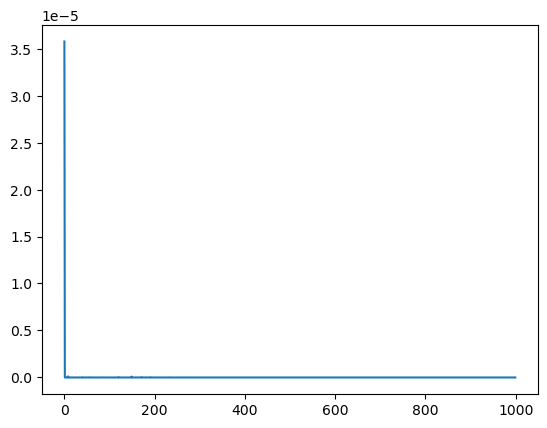

In [ ]:
import matplotlib.pyplot as plt

plt.plot(weights['t'])
plt.show()

In [ ]:
weights['t']

array([3.57516817e-005, 6.38097910e-010, 1.26551871e-009, 5.65784545e-010,
       6.84746215e-009, 4.23959112e-010, 4.69052367e-010, 1.90345229e-010,
       1.18961479e-007, 2.42427367e-010, 6.24817695e-010, 6.30192324e-010,
       5.34102407e-009, 3.81554023e-010, 3.92604432e-010, 1.37302201e-009,
       4.10151125e-010, 3.27600312e-009, 5.87660399e-010, 1.60938069e-009,
       4.42276313e-010, 3.56044623e-010, 2.17763640e-009, 1.87663372e-009,
       4.69655325e-009, 2.56432930e-009, 1.64495393e-008, 3.42025844e-010,
       2.22096834e-010, 4.61190795e-009, 1.56722240e-009, 4.22186233e-010,
       5.37612165e-010, 5.96427038e-010, 1.78290675e-009, 6.42317986e-010,
       2.35613432e-010, 3.56055923e-010, 3.11344041e-010, 2.77605132e-010,
       2.70553919e-008, 5.03316259e-010, 6.01998453e-010, 2.04735312e-009,
       5.29478034e-010, 3.25886424e-009, 4.44169857e-009, 6.10838955e-010,
       3.30199282e-010, 6.40932178e-010, 4.39464027e-010, 1.61143610e-009,
       2.88315355e-010, 2